In [1]:
###HYPERPARAMETERS###
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, logging
import transformers
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
import json
import argparse
import csv
import random
from torch.utils.data import Dataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
logging.set_verbosity_error()
random.seed(42)

model_path = "mistralai/Mistral-7B-Instruct-v0.2"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Load the tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = "!"

In [3]:
## Load the trained model

device = "cuda" if torch.cuda.is_available() else "cpu"
load_in_4_bit = True if device == "cuda" else False
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, load_in_4bit=load_in_4_bit, device_map="auto")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Load model with attention weights in 16 bit quantization:

#model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, load_in_4bit=False, device_map="cpu") # very slow inference time

In [5]:
## Load the inital completely randomized model

# Load configuration
#config = AutoConfig.from_pretrained(model_path)
#print(config)

# Instantiate model with random weights
#model_with_random_weights = AutoModelForCausalLM.from_config(config, torch_dtype=torch.float16)
#model = model_with_random_weights.to(device)

In [6]:
SEP_TOKEN = "[/INST]"
INPUT_LENGTH = 150
LABEL_LENGTH = 150
random.seed(44)
import re


def add_prefix(prompt_prefix):
    message = [
        # {"role": "system", "content": "You are a helpful assistant who follows the following pattern."}, Not
        {"role": "user",
         "content": prompt_prefix},
        {"role": "assistant", "content": "Ok!"},
    ]
    return message


def give_example(word, target=None):
    user_prompt = {
        "role": "user", "content": f"Word: {word}"}
    if target:
        assistant_prompt = {"role": "assistant", "content": str(target) + "#"}
        return [user_prompt, assistant_prompt]
    return [user_prompt]


def get_examples(df, max_examples=2):
    #random.seed(44)
    examples = []
    n_elem = len(df)
    for _ in range(max_examples):
        random_index = random.randint(0, n_elem - 1)  # same index is possible, but occurs very rarely
        row = df.iloc[random_index]
        example = give_example(row["Word"], row["Clue"])
        examples += example
    return examples


def generate_prompts(data, data_train, n_prompts, prompt_prefix, clue_visible=True):
    prompts = []
    for _, (_, row) in enumerate(data.iterrows()):
        message = add_prefix(prompt_prefix)
        examples = get_examples(data_train, max_examples=n_prompts)
        message += examples
        test_example = give_example(row["Word"], row["Clue"] if clue_visible else None)
        message += test_example
        prompts.append(message)
    return prompts


def tokenize(prompt, tokenizer, return_tensors=None, cutoff_len=1500, padding=True):
    if padding:
        return tokenizer(
            prompt + tokenizer.eos_token,
            truncation=True,
            max_length=cutoff_len,
            padding="max_length",
            return_tensors=return_tensors
        )
    else:
        return tokenizer(
            prompt + tokenizer.eos_token,
            truncation=True,
            return_tensors=return_tensors
        )


def tokenize_prompts(prompts, tokenizer):
    tokenized_prompts, tokenized_labels = [], []
    for prompt in tqdm(prompts):
        prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)
        prompt_splitted = prompt.split(SEP_TOKEN)
        input_str = SEP_TOKEN.join(prompt_splitted[:-1]) + SEP_TOKEN
        output_str = prompt_splitted[-1]
        input_tokenized = tokenize(
            input_str, tokenizer, return_tensors="pt", cutoff_len=INPUT_LENGTH + LABEL_LENGTH)
        output_tokenized = tokenize(
            output_str, tokenizer, return_tensors="pt", padding=False)
        tokenized_prompts.append(input_tokenized)
        tokenized_labels.append(output_tokenized)
    return tokenized_prompts, tokenized_labels


def tokenize_prompts_without_final_label(prompts, tokenizer):
    tokenized_prompts = []
    for prompt in tqdm(prompts):
        input_str = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)
        input_tokenized = tokenize(input_str, tokenizer, return_tensors="pt", cutoff_len=INPUT_LENGTH + LABEL_LENGTH)
        tokenized_prompts.append(input_tokenized)
    return tokenized_prompts


class CustomDataset(Dataset):
    def __init__(self, prompts, outputs):
        self.prompts = prompts
        self.outputs = outputs

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, index):
        # We ignore input text, except where the labels begin
        ignore_input_text = torch.tensor(
            [-100] * (INPUT_LENGTH + LABEL_LENGTH - len(self.outputs[index]['input_ids'][0])))

        label_ids = torch.cat(
            (ignore_input_text, self.outputs[index]["input_ids"][0]), dim=0)
        attention_mask = self.prompts[index]['attention_mask']
        input_ids = self.prompts[index]['input_ids']

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label_ids}


def postprocess_generated_text(text):
    text = text.split("\n")[0]
    text = text.split("#")[0]
    if text[0:3] == "1. ":
        text = text[3:]
    if text[-1] == "(" and text[-3] == ")":
        text = text[:-3]
    return text


def predict_new_examples(prompts, tokenized_prompts, model, df_words, tokenizer, device, token_level=False, print_output=False, print_attention_maps=False, attention_step_size = 10, attention_out_path = "", embedding=None):
    predictions = []

    for index in range(len(tokenized_prompts)):


        def visualize_attention_maps(filtered_tokens, token_level, stepsize=10, out_path=""):
            out = model(**tokenized_prompt.to(device), output_attentions=True)
            attentions = out.attentions
            #seq_begin = np.where(np.array(tokens) == "Ok")[0][0] + 2
            
            l = len(indices)
            cos_similarity_matrix = np.zeros((l, l)).astype(np.float32)
            for i in range(l):
                for j in range(0, i + 1):
                    embedding_i = embedded_seq[indices[i]].cpu().detach().numpy()
                    embedding_j = embedded_seq[indices[j]].cpu().detach().numpy()
                    cos_similarity = np.dot(embedding_i, embedding_j) / (np.linalg.norm(embedding_i) * np.linalg.norm(embedding_j))
                    cos_similarity_matrix[i, j] = cos_similarity

            

            filtered_tokens = [w.replace('Word' , 'Word:') for w in filtered_tokens]
            for j in range(len(filtered_tokens) - 1, -1, -1):
                if filtered_tokens[j] == "Word:":
                    filtered_tokens[j] = "Target Word:"
                    break
                
            #plot_attention_map(f"Cosine Similarities", f"Cosine Similarities for Target Clue Ant", cos_similarity_matrix, filtered_tokens, out_path)
            plot_attention_maps(target_word, attentions, desired_words, filtered_tokens, index_groups, indices, token_level, stepsize, out_path)



        prompt = prompts[index]
        desired_words = []
        for message in prompt[2:]:
            sentence = re.findall(r"\b\w+(?:'\w+)?\b", message["content"])
            desired_words += sentence


        tokenized_prompt = tokenized_prompts[index]

        token_seq = tokenized_prompt["input_ids"][0]

        embedded_seq = embedding[token_seq]
        #print(embedded_seq.shape) #4096

        input_text = tokenizer.decode(tokenized_prompt["input_ids"][0], skip_special_tokens=True)
        tokens = tokenizer.convert_ids_to_tokens(tokenized_prompt["input_ids"][0])
        filtered_tokens, indices = get_filtered_tokens_and_indices(tokens)
        index_groups = summarize_token_ids(filtered_tokens, indices, desired_words)

        target_word = df_words["Word"][index]

        # Replace Padding Token
        #print("\nInput Text: {}".format(input_text.replace("!", "")))

        if print_output:
            print("\n-----Example {}----".format(index + 1))
            print("\nWord: {}".format(target_word))

        

        if print_attention_maps:
            visualize_attention_maps(filtered_tokens, token_level, stepsize=attention_step_size, out_path=attention_out_path)

        output = model.generate(**tokenized_prompt.to(device), max_new_tokens=50)
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

        generated_prediction = generated_text.split("[/INST]")[-1]
        prediction = postprocess_generated_text(generated_prediction)
        predictions.append(prediction)

        if print_output:
            print("\nGenerated Clue: {}".format(prediction))


    return predictions


def plot_attention_map(title, save_title, attention_map, tokens, out_path):

    # Ensure the size of the attention map matches the number of tokens
    assert attention_map.shape[0] == attention_map.shape[1] == len(tokens) == attention_map.shape[1], "Attention map dimensions must match the number of tokens."

    plt.figure(figsize=(10, 8))
    plt.xlabel("Tokens (from)")
    plt.ylabel("Tokens (to)")
    plt.title(title)
    hm = sns.heatmap(attention_map, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    hm.get_figure().savefig(f"{out_path}{save_title}.png", format="png", bbox_inches='tight')
    plt.show()


def plot_attention_maps(word, attentions, desired_words, filtered_tokens, index_groups, indices, token_level, stepsize=5, out_path = ""):
    #filtered_tokens = [w.replace('Word' , 'Word:') for w in filtered_tokens]
    #for j in range(len(filtered_tokens) - 1, -1, -1):
    #    if filtered_tokens[j] == "Word:":
    #        filtered_tokens[j] = "Target Word:"
    #        break
    for i, attention_map in enumerate(attentions):
        if i % stepsize != 0:
            continue
        attention_map = attention_map.mean(dim=1).squeeze().cpu().detach().numpy()
        first_indices = [index_group[0] for index_group in index_groups]
        last_indices = [index_group[-1] for index_group in index_groups]
        filtered_attention_map = attention_map[np.ix_(indices, indices)]
        target_attention_map = attention_map[np.ix_(first_indices, first_indices)] * 0
        for ind1 in range(len(index_groups)):
            for ind2 in range(len(index_groups)):
                first_index_1, first_index_2 = first_indices[ind1], first_indices[ind2]
                last_index_1, last_index_2 = last_indices[ind1], last_indices[ind2]
                for ix in range(first_index_1, last_index_1 + 1):
                    for iy in range(first_index_2, last_index_2 + 1):
                        target_attention_map[ind1, ind2] += attention_map[ix, iy]

        
        if token_level == True:
        
        
            plot_attention_map(f"Layer {i + 1}",  f"Attention Map for Target Clue {word}, Layer {i + 1}", filtered_attention_map, filtered_tokens, out_path)
        else:

            desired_words = [f"{desired_word}" for desired_word in desired_words if desired_word != ""]

            desired_words_plot = []
            for j, desired_word in enumerate(desired_words):
                if desired_word == "Word":
                    if j == len(desired_words) - 2: 
                        desired_words_plot.append(f"Target Word:")
                    else:
                        desired_words_plot.append(f"Word:")
                else:
                    desired_words_plot.append(desired_word)

            plot_attention_map(f"Layer {i + 1}", f"Attention Map for Target Clue {word}, Layer {i + 1}", target_attention_map, desired_words_plot, out_path)

        #layer = 15
        #for i in range(len(attentions)):
            #attention_map = attentions[layer][:, i].squeeze().cpu().detach().numpy()
            #filtered_attention_map = attention_map[np.ix_(indices, indices)]
            #plot_attention_map(f"Attention Map Layer {layer  + 1} with head {i + 1}", filtered_attention_map, tokens, out_path)

def get_filtered_tokens_and_indices(tokens):
        indices = []
        control, active = False, False
        for i, token in enumerate(tokens):
            if token == "Ok":
                control = True
                active = False
            if token == ":" or token == "]":
                active = True
                continue
            elif token == "▁[" or token == "#" or token == "</s>":
                active = False
            if control and active:
                indices.append(i)

        filtered_tokens = np.array(tokens)[indices]

        for i in range(len(filtered_tokens)):
            if filtered_tokens[i][0] == "▁":
                filtered_tokens[i] = filtered_tokens[i][1:]

        return filtered_tokens, indices


def summarize_token_ids(tokens, indices, words):
    words_index, letter_index = 0, 0
    index_groups, index_group = [], []
    for (token, index) in zip(tokens, indices):
        if token == words[words_index][letter_index:letter_index + len(token)]:
            letter_index += len(token)
            index_group.append(index)
            if letter_index == len(words[words_index]):
                index_groups.append(index_group)
                words_index += 1
                letter_index = 0
                index_group = []
    return index_groups




In [7]:
def generate(n_words, n_shots, model, tokenizer, input_words_file_path, input_words_clues_path, output_words_clues_path, prompt_prefix, token_level, print_output, save_output, print_attention_maps, attention_step_size, attention_out_path, device, embedding):



    ###CEATE TRAIN DATASET AND READ WORDS###

    words = []
    with open(input_words_file_path, 'r') as file:
        for line in file:
            words.append(line.strip())

    category = words[0]
    words = words[1: 1 + n_words]
    df_new_words = pd.DataFrame(words, columns=['Word'])

    df_train = pd.read_csv(input_words_clues_path, sep=";", encoding='latin1')
    df_train, temp = train_test_split(df_train, test_size=0.01, random_state=42)

    # normalize index
    df_train.reset_index(drop=True, inplace=True)

    # get percentage of dataset to improve runtime
    TRAIN_PERCENTAGE = 1  # percentage of train data used
    df_train = df_train.head(int(len(df_train) * TRAIN_PERCENTAGE))

    new_prompts = generate_prompts(df_new_words, df_train, n_shots, prompt_prefix, clue_visible=False)
    

    new_tokenized_prompts = tokenize_prompts_without_final_label(new_prompts, tokenizer)

    ###GENERATE###

    predicted_clues = predict_new_examples(new_prompts, new_tokenized_prompts, model, df_new_words, tokenizer, device, token_level, print_output, print_attention_maps, attention_step_size, attention_out_path, embedding)

    #if print_output:
    #    for index in range(len(predicted_clues)):
    #        print("\n-----Word {}----".format(index + 1))
    #        print("\nWord: {}".format(words[index]))
    #        print("\nGenerated Clue: {}".format(predicted_clues[index]))
    
    if save_output:
        with open(output_words_clues_path, 'w', newline='') as file:
            writer = csv.writer(file, delimiter=";")
            writer.writerow(["Word", "Clue"])
            for clue_word_pair in zip(words, predicted_clues):
                writer.writerow(clue_word_pair)

100%|██████████| 5/5 [00:00<00:00, 94.15it/s]



-----Example 1----

Word: Ant


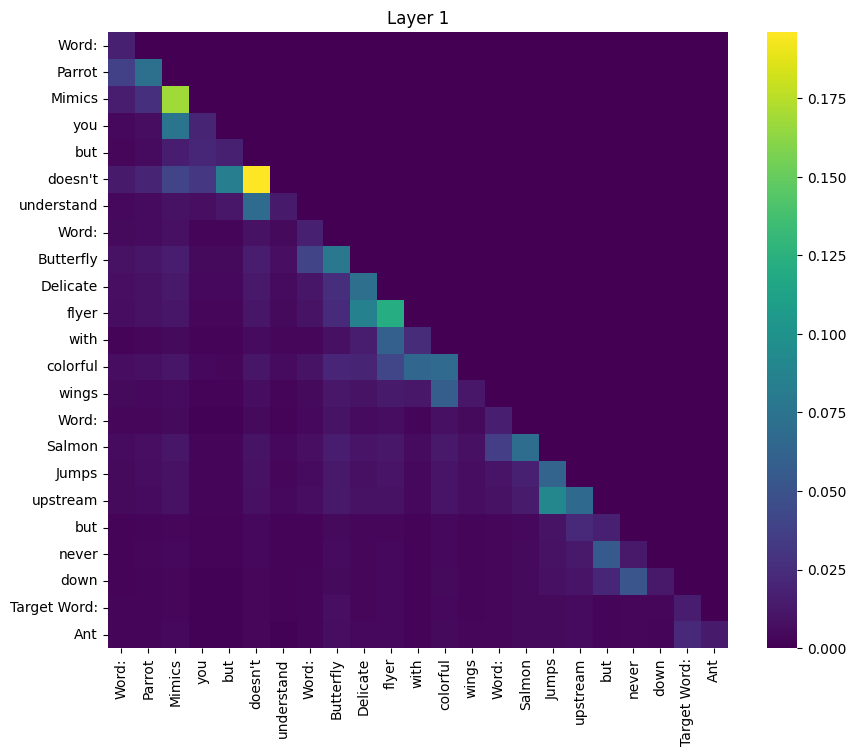

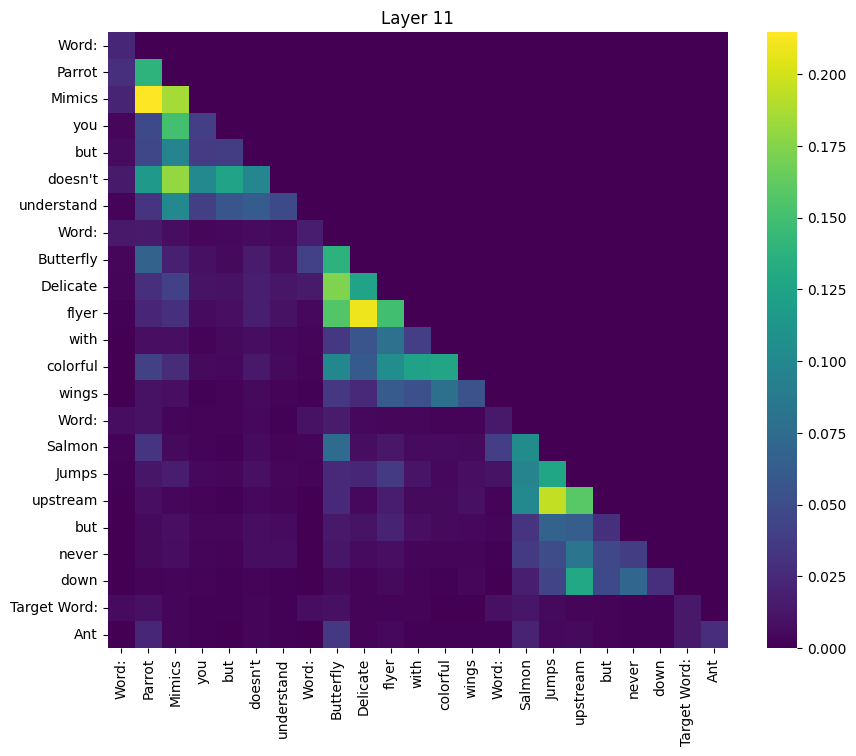

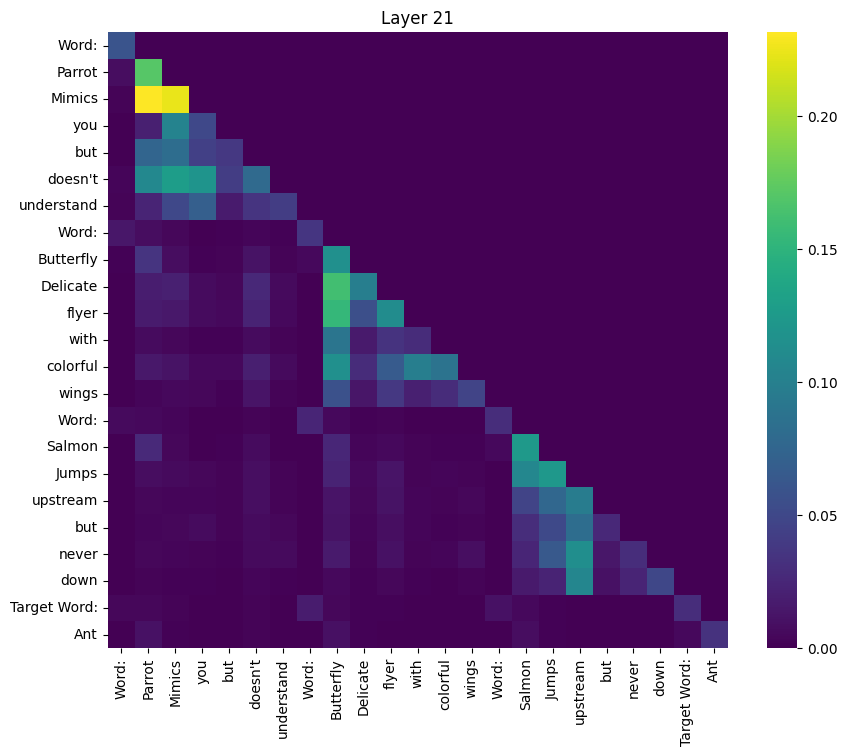

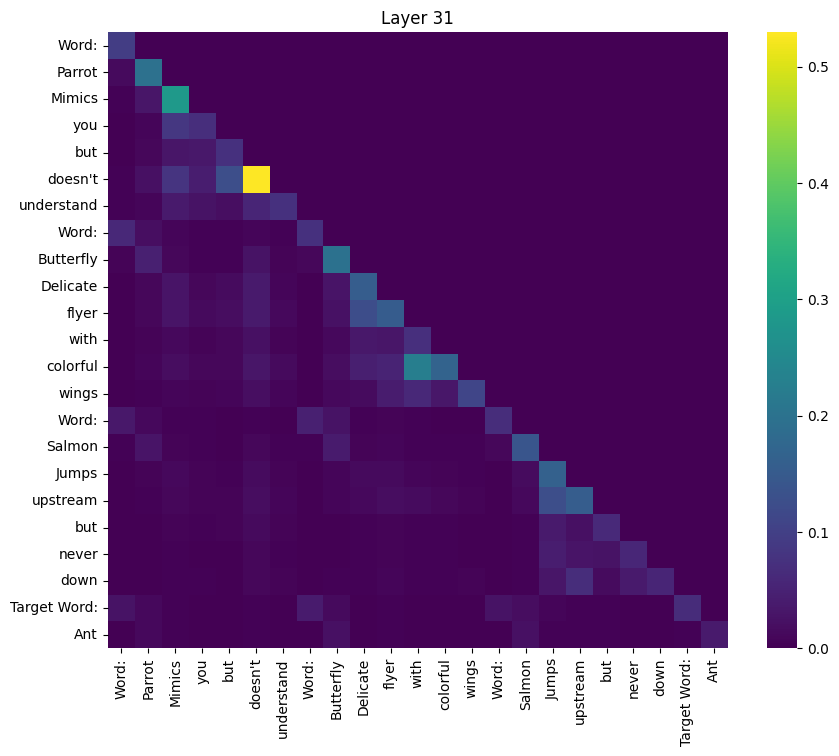


Generated Clue:  Small, yet mighty workers in a complex society.

-----Example 2----

Word: Bee


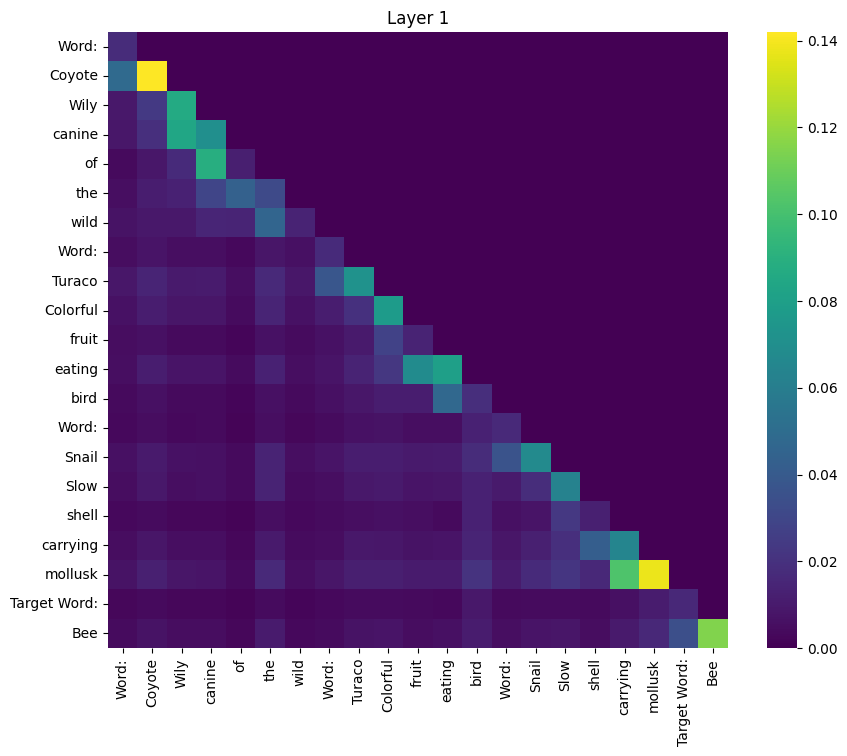

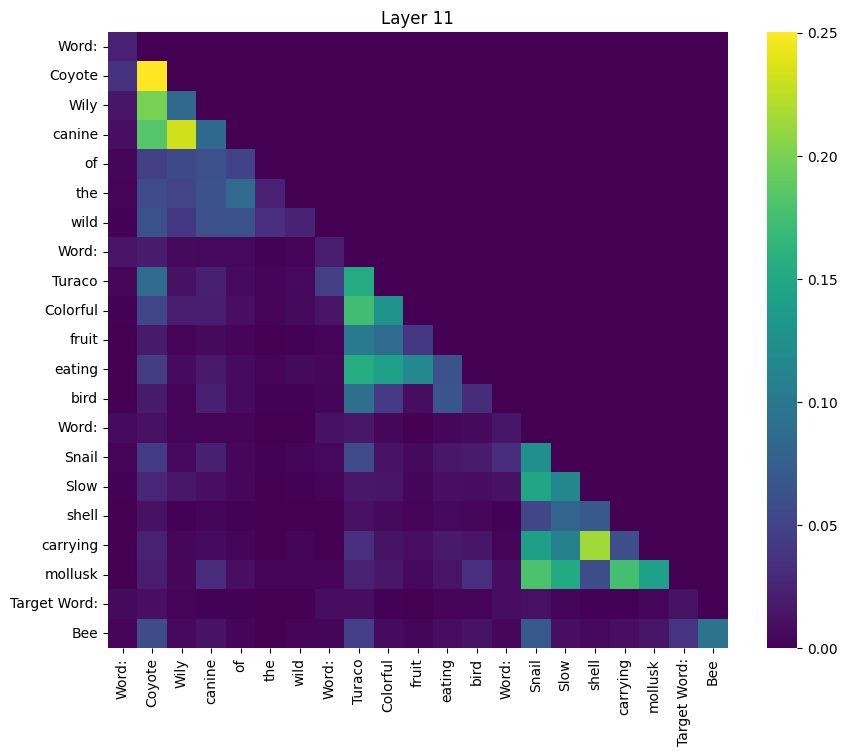

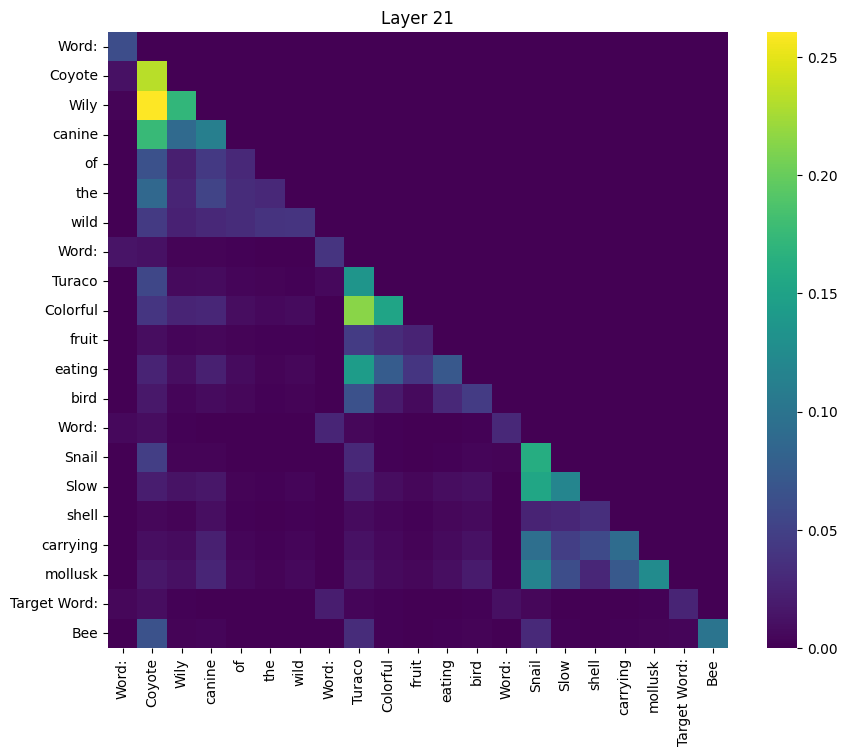

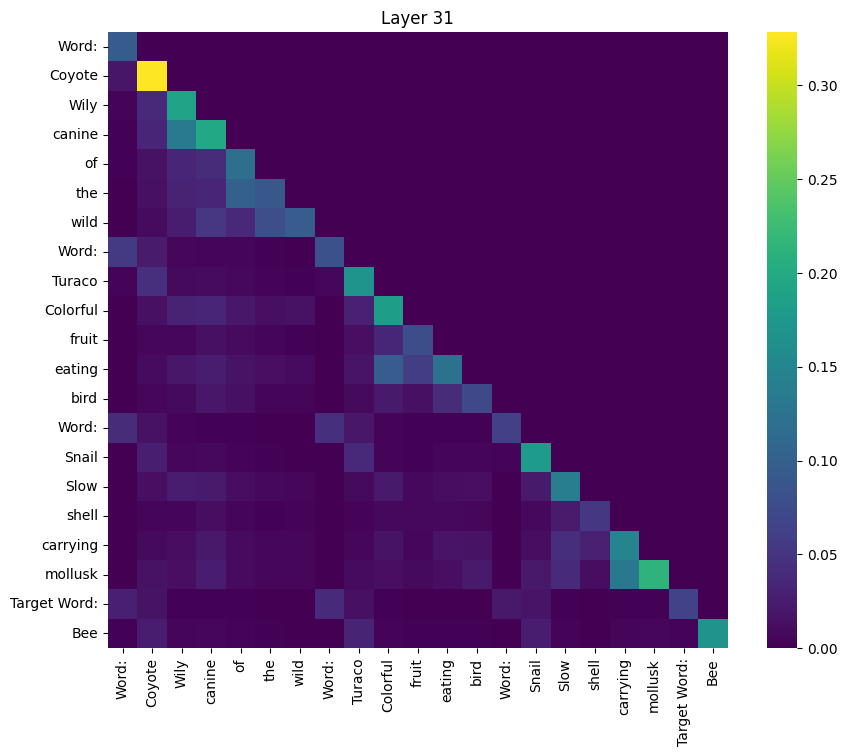


Generated Clue: Honey-producing insect.

-----Example 3----

Word: Fox


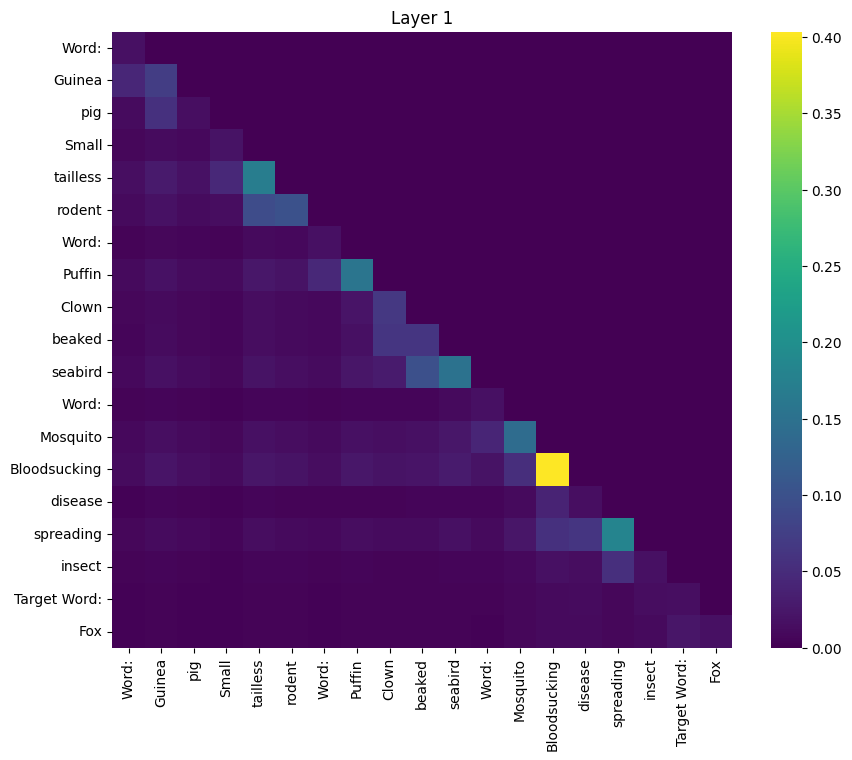

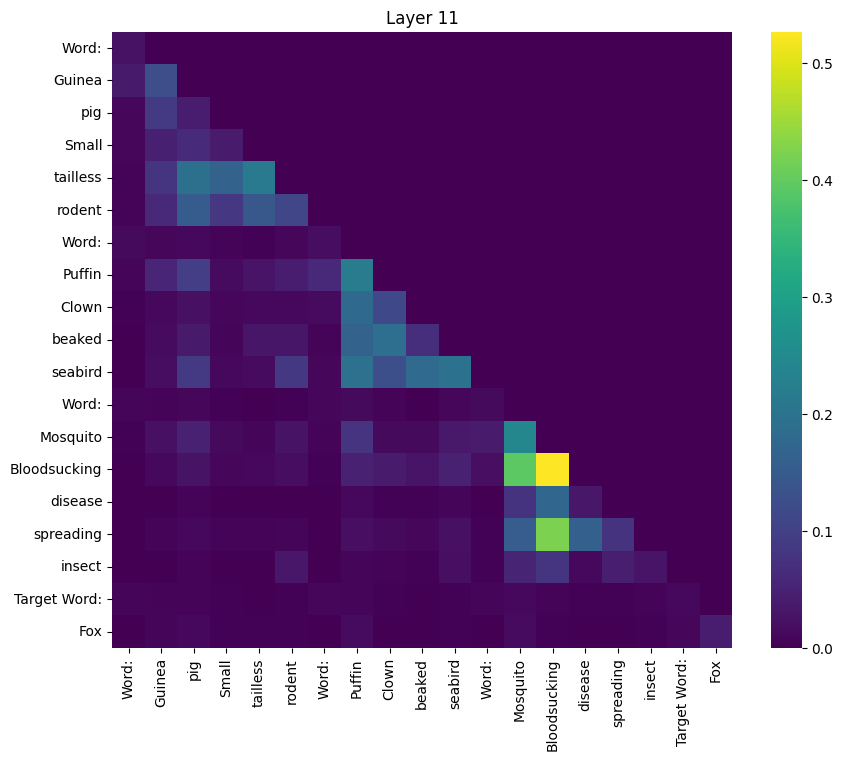

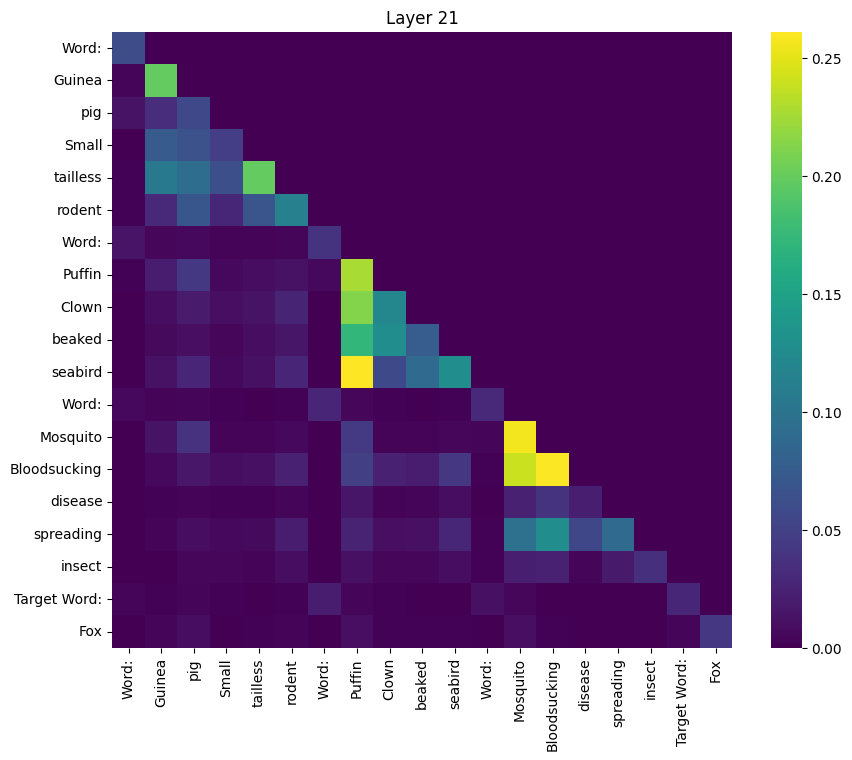

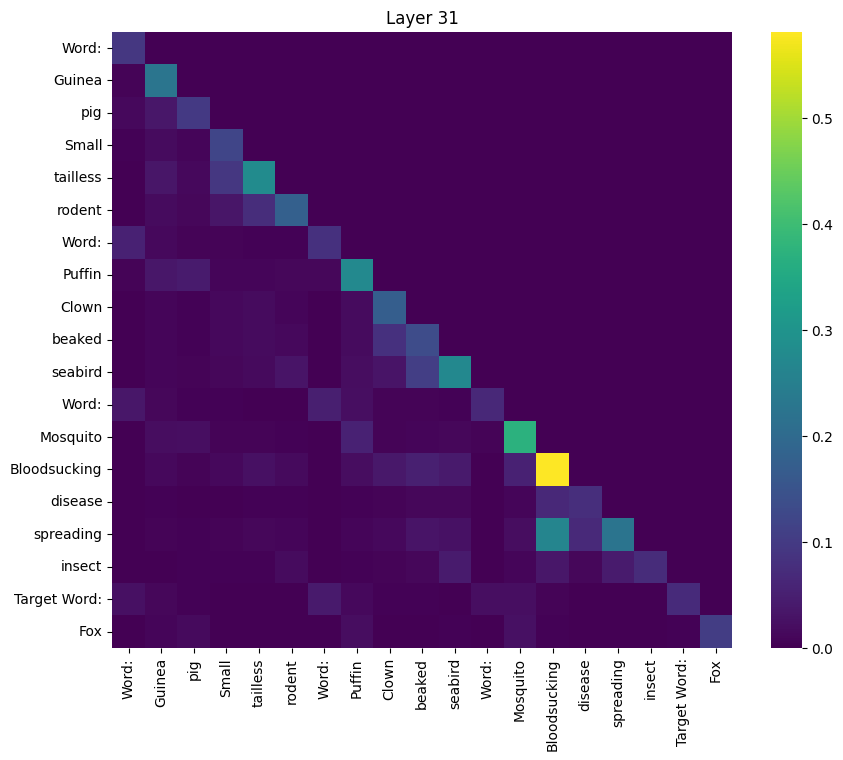


Generated Clue: Cunning, red-hued forest dweller.

-----Example 4----

Word: Raven


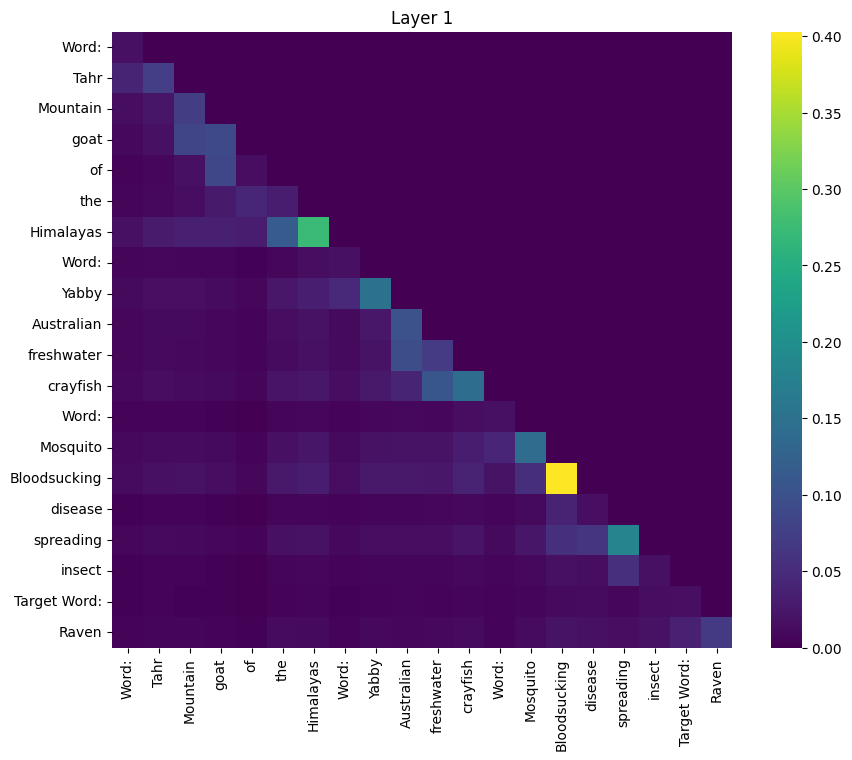

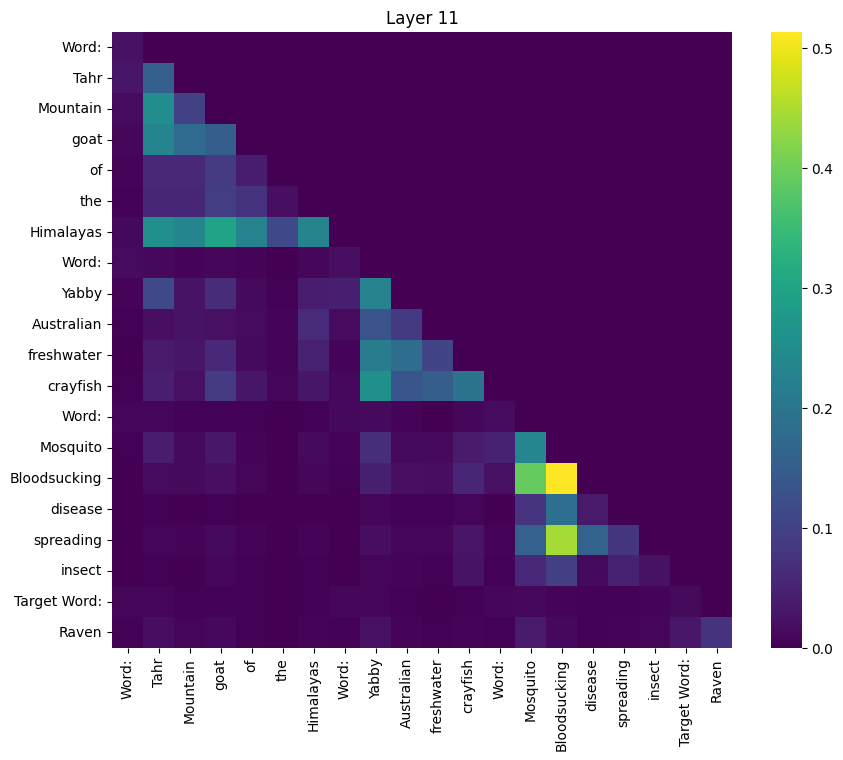

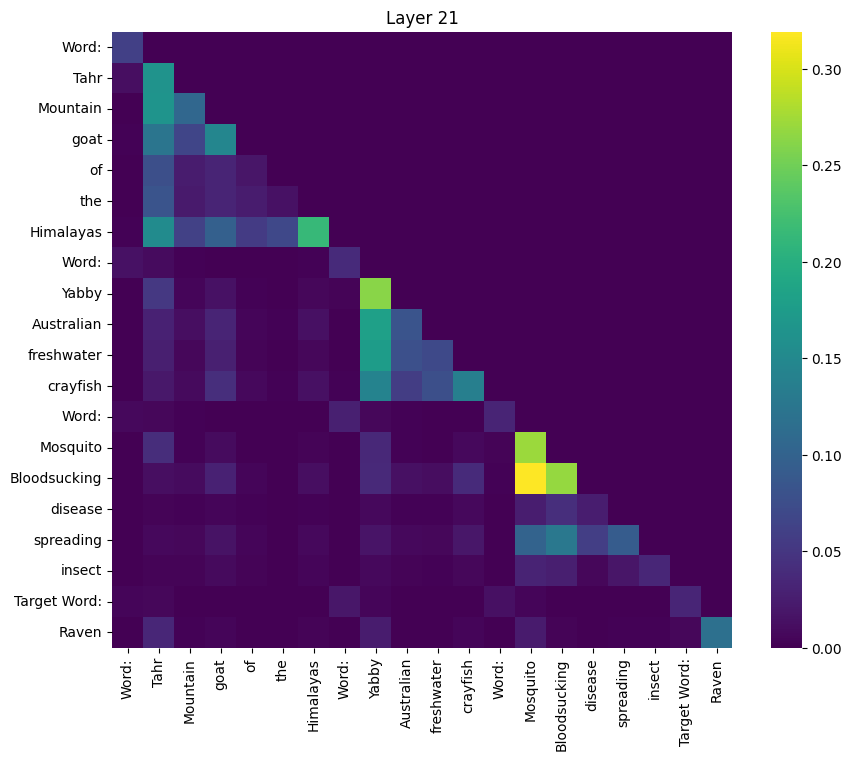

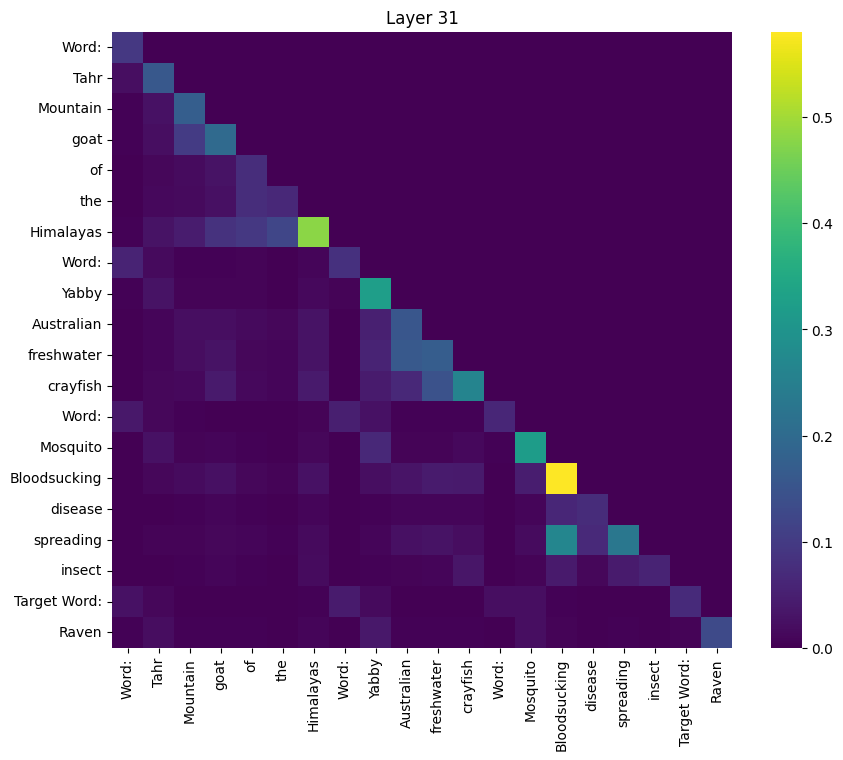


Generated Clue:  Large, black bird with a complex call.

-----Example 5----

Word: Tarantula


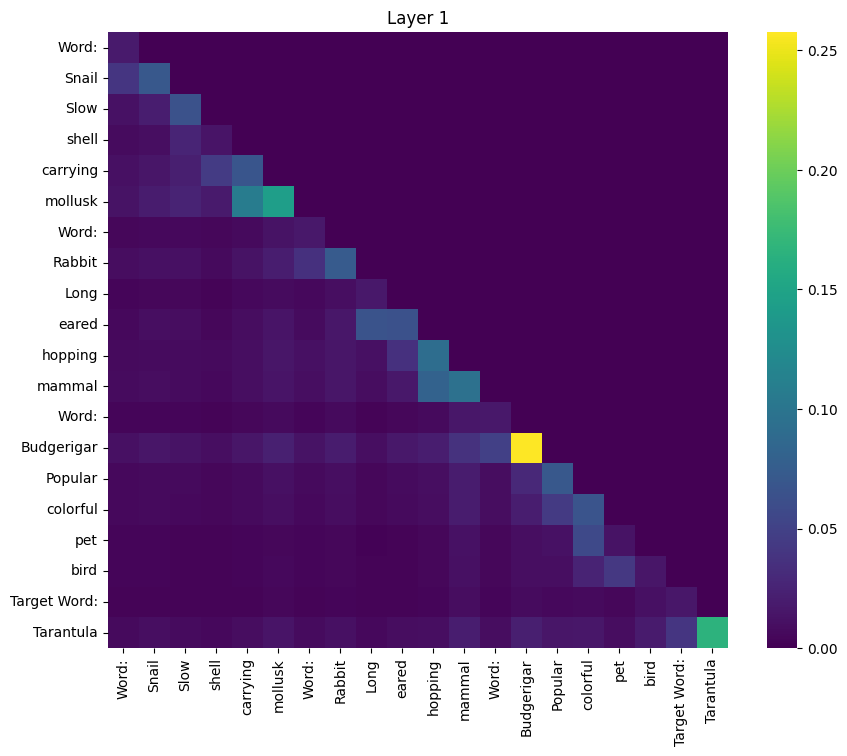

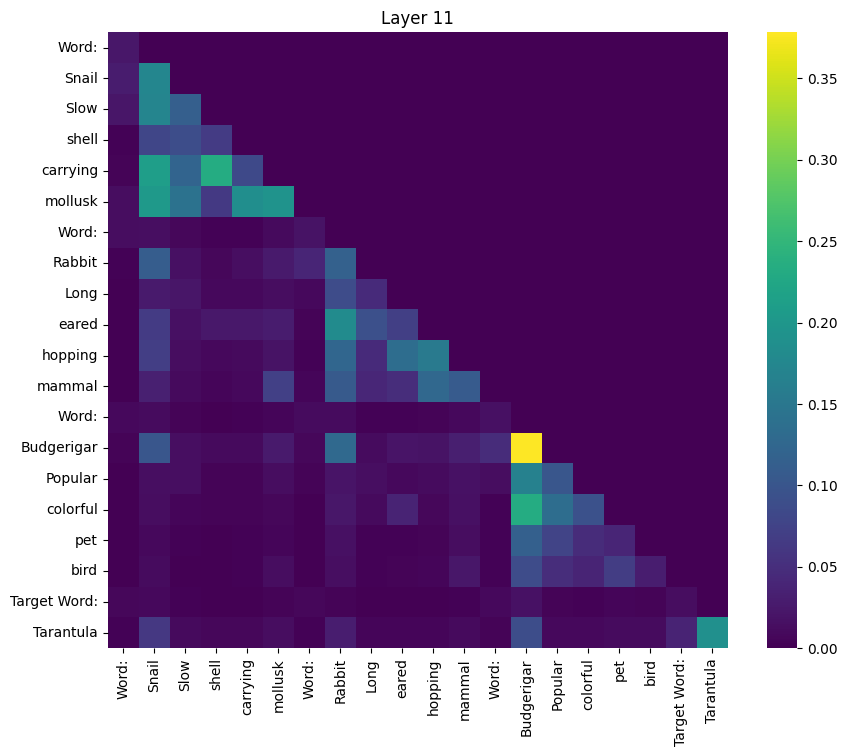

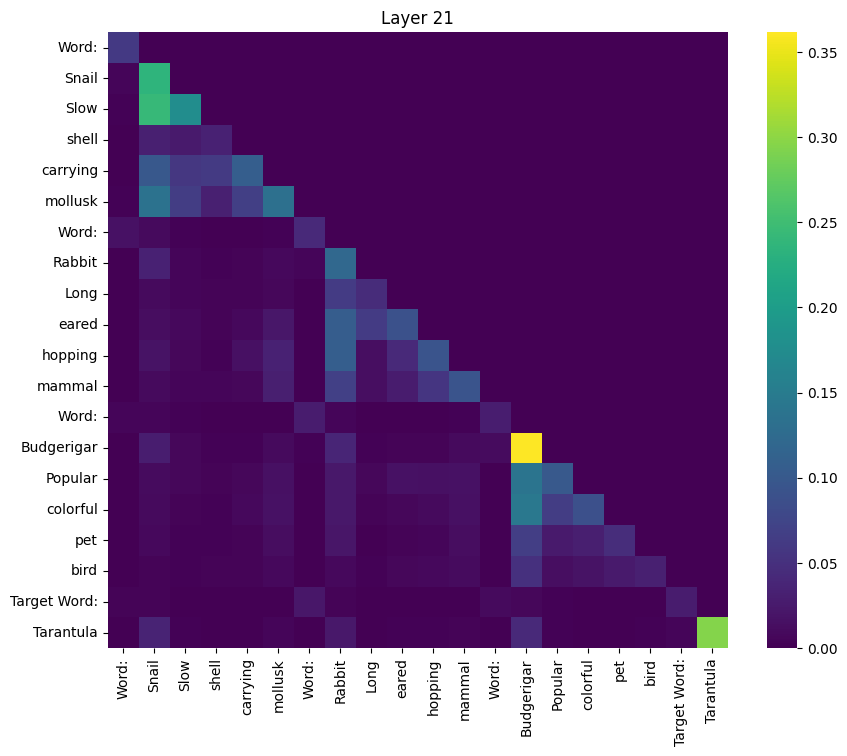

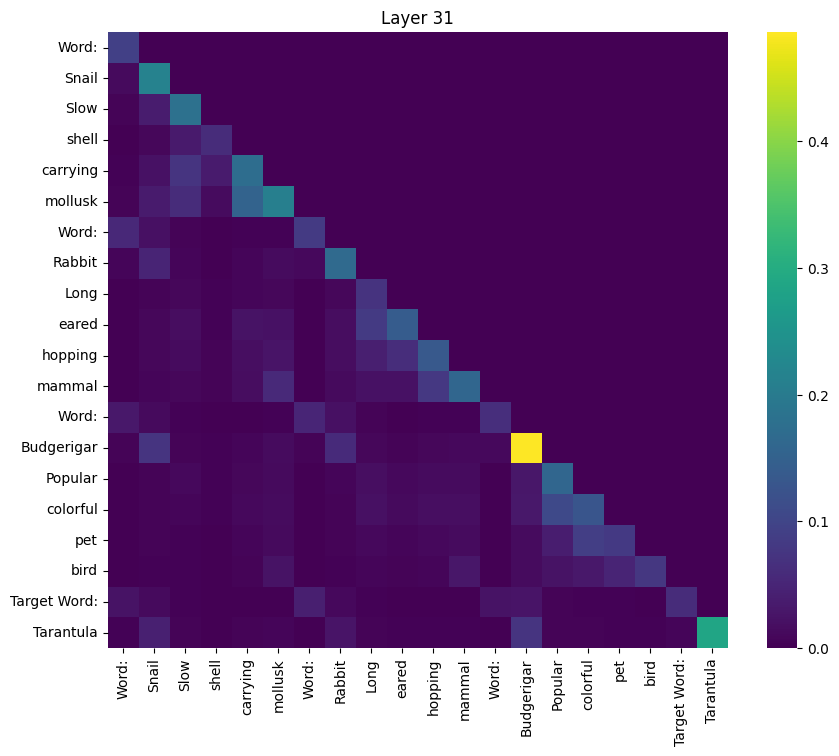


Generated Clue: Large, hairy, venomous arachnid.


In [8]:
N_SHOTS = 3
N_WORDS = 5
MODEL = model # "mistralai/Mistral-7B-Instruct-v0.2"
TOKENIZER = tokenizer
INPUT_WORDS_FILE_PATH = "animals_dummy_words.txt"
INPUT_WORDS_CLUES_FILE_PATH = "animals_dummy_words_clues.csv"
OUTPUT_WORDS_CLUES_FILE_PATH = "words_generated_clues.csv"
CATEGORY = "Animals"

PROMPT_PREFIX = f"You are a crossword clue generator and have to generate a short clue for each input word from the category {CATEGORY}. I will give you a word and you have to output a brief description " + \
                "related of the word, which will be engaging and challenging. Just give one answer, marking the end with a #."

PRINT_OUTPUT = True
SAVE_OUTPUT = True
PRINT_ATTENTION_MAPS = True
TOKEN_LEVEL = False
ATTENTION_STEP_SIZE = 10
ATTENTION_OUT_PATH = "thesis_attention_maps_stats/"

def get_embedding():
    for name, param in model.named_parameters():
        if name == "model.embed_tokens.weight":
            return param
        
embedding = get_embedding()


generate(N_WORDS, N_SHOTS, MODEL, TOKENIZER, INPUT_WORDS_FILE_PATH, INPUT_WORDS_CLUES_FILE_PATH, OUTPUT_WORDS_CLUES_FILE_PATH, PROMPT_PREFIX, TOKEN_LEVEL, PRINT_OUTPUT, SAVE_OUTPUT, PRINT_ATTENTION_MAPS, ATTENTION_STEP_SIZE, ATTENTION_OUT_PATH, device, embedding)


In [9]:
STATS_SAVE_PATH = "singular_value_statistics/"

def get_qkv_matrix_from_layer_l(model, l):
    tag = f".{l}" # ".{l}"
    q_matix, k_matrix, v_matrix = None, None, None
    for name, module in model.named_modules():
        if hasattr(module, 'weight') and isinstance(module.weight, torch.Tensor):
            if f"{tag}.self_attn.q" in name:
                q_matix = module.weight.cpu()
            elif f"{tag}.self_attn.k" in name:
                #module.weight.data = module.weight * alpha
                k_matrix = module.weight.cpu()
            elif f"{tag}.self_attn.v" in name:
                v_matrix = module.weight.cpu()
    return q_matix.to(dtype=torch.float32), k_matrix.to(dtype=torch.float32), v_matrix.to(dtype=torch.float32)

def get_mlp_up_down_matrix_from_layer_l(model, l):
    tag = f".{l}" # ".{l}"
    up_matrix, down_matrix = None, None
    for name, module in model.named_modules():
        if hasattr(module, 'weight') and isinstance(module.weight, torch.Tensor):
            if f"{tag}.mlp.up_proj" in name:
                up_matrix = module.weight.cpu()
            elif f"{tag}.mlp.down_proj" in name:
                down_matrix = module.weight.cpu()
    return up_matrix.to(dtype=torch.float32), down_matrix.to(dtype=torch.float32)

def get_svd(weight_matrix):
    U, D, Vh = torch.svd(weight_matrix.to(dtype=torch.float32))
    return U, D, Vh


def scale_matrix(model, module_name, alpha = 1., beta = 0.):
    for name, module in model.named_modules():
        if hasattr(module, 'weight') and isinstance(module.weight, torch.Tensor):
            if module_name in name:
                module.weight.data = module.weight * alpha + beta

def change_svd_matrix(model, module_name, mean = 0., std = 0.2):
    for name, module in model.named_modules():
        if hasattr(module, 'weight') and isinstance(module.weight, torch.Tensor):
            if module_name in name:
                U, D, Vh = torch.svd(module.weight.to(dtype=torch.float32))
                U2, D2, Vh2 = torch.svd(torch.normal(mean, std, module.weight.shape))
                new_weight = (torch.matmul(U, torch.matmul(torch.diag(D), Vh2.T)) * alpha).to(torch.float16)
                module.weight.data = new_weight

def print_singular_value_statistics(D, name):
    print(f"Average Squared Singular Value {name}", torch.mean(D**2).item())
    print(f"Variance Squared Singular Value {name}", torch.var(D**2).item())
    print(f"Largest Squared Singular Value {name}", torch.max(D**2).item())
    print(f"Largest 10 Squared Singular Values {name}", (D[:10] ** 2).detach().numpy())

def plot_singular_values_q_k_v(DQ, DK, DV, l, tag = "learned"):
    for factor, prefix in zip([1, 2], ["", "Squared"]):
        plt.figure()
        plt.plot((DQ ** factor).cpu().detach().numpy())
        plt.plot((DK ** factor).cpu().detach().numpy())
        plt.plot((DV ** factor).cpu().detach().numpy())
        plt.legend([f"{prefix} Singular Values W_q", f"{prefix} Singular Values W_K", f"{prefix} Singular Values W_v"])
        plt.title(f"{prefix} Singular Values of W_q, W_k and W_v in layer {l + 1}")
        plt.savefig(f"{STATS_SAVE_PATH}{prefix} Singular Values of W_q, W_k and W_v in layer {l + 1}_{tag}")
        plt.show()

def plot_singular_values_mlp_up_down(DUp, DDown, l, tag = "learned"):
    for factor, prefix in zip([1, 2], ["", "Squared"]):
        plt.figure()
        plt.plot((DUp ** factor).cpu().detach().numpy())
        plt.plot((DDown ** factor).cpu().detach().numpy())
        plt.legend([f"{prefix} Singular Values W_Up", f"{prefix} Singular Values W_Down"])
        plt.title(f"{prefix} Singular Values of W_Up and W_Down in layer {l + 1}")
        plt.savefig(f"{STATS_SAVE_PATH}{prefix} Singular Values of W_Up and W_Down in layer {l + 1}_{tag}")
        plt.show()

def plot_singular_values_squared_with_scaling_interval(D, name, l, tag = "learned"):
    mean, std = torch.mean(D).item(), torch.std(D).item()
    n = len(D)
    plt.figure()
    plt.plot((D**2).cpu().detach().numpy())
    plt.plot(torch.ones(n) * (mean - std))
    plt.plot(torch.ones(n) * mean)
    plt.plot(torch.ones(n) * (mean + std))
    plt.title(f"Squared Singular Values {name} in layer {l + 1} with scaling interval")
    plt.legend([f"Squared Singular Values {name}", "Mean - Std", "Mean", "Mean + Std"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values {name} in layer {l + 1} with scaling interval_{tag}")
    plt.show()

def plot_singular_values_statistics_q_k_v(model, num_layers):
    singular_values_q_means, singular_values_q_vars, singular_values_q_maxs = [], [], []
    singular_values_k_means, singular_values_k_vars, singular_values_k_maxs = [], [], []
    singular_values_v_means, singular_values_v_vars, singular_values_v_maxs = [], [], []
    for i in range(num_layers):
        q_matrix, k_matrix, v_matrix = get_qkv_matrix_from_layer_l(model, i)
        q_singular_values, k_singular_values, v_singular_values = torch.linalg.svdvals(q_matrix) ** 2, torch.linalg.svdvals(k_matrix) ** 2, torch.linalg.svdvals(v_matrix) ** 2
        singular_values_q_means.append(torch.mean(q_singular_values).item())
        singular_values_q_vars.append(torch.var(q_singular_values).item())
        singular_values_q_maxs.append(torch.max(q_singular_values).item())
        singular_values_k_means.append(torch.mean(k_singular_values).item())
        singular_values_k_vars.append(torch.var(k_singular_values).item())
        singular_values_k_maxs.append(torch.max(k_singular_values).item())
        singular_values_v_means.append(torch.mean(v_singular_values).item())
        singular_values_v_vars.append(torch.var(v_singular_values).item())
        singular_values_v_maxs.append(torch.max(v_singular_values).item())
     
    plt.figure()
    plt.plot(singular_values_q_means)
    plt.plot(singular_values_k_means)
    plt.plot(singular_values_v_means)
    plt.title(f"Squared Singular Values Means in Q, K, and V for each layer")
    plt.legend([f"Squared Singular Values Means Q", "Squared Singular Values Means K", "Squared Singular Values Means V"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values Means in Q, K, and V for each layer")
    plt.show()

    plt.figure()
    plt.plot(singular_values_q_vars)
    plt.plot(singular_values_k_vars)
    plt.plot(singular_values_v_vars)
    plt.title(f"Squared Singular Values Vars in Q, K, and V for each layer")
    plt.legend([f"Squared Singular Values Vars Q", "Squared Singular Values Vars K", "Squared Singular Values Vars V"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values Vars in Q, K, and V for each layer")
    plt.show()

    plt.figure()
    plt.plot(singular_values_q_maxs)
    plt.plot(singular_values_k_maxs)
    plt.plot(singular_values_v_maxs)
    plt.title(f"Squared Singular Values Max in Q, K, and V for each layer")
    plt.legend([f"Squared Singular Values Max Q", "Squared Singular Values Max K", "Squared Singular Values Max V"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values Max in Q, K, and V for each layer")


def plot_singular_values_statistics_up_down(model, num_layers):
    singular_values_up_means, singular_values_up_vars, singular_values_up_maxs = [], [], []
    singular_values_down_means, singular_values_down_vars, singular_values_down_maxs = [], [], []
    for i in range(num_layers):
        mlp_up_matrix, mlp_down_matrix = get_mlp_up_down_matrix_from_layer_l(model, i)
        mlp_up_singular_values, mlp_down_singular_values = torch.linalg.svdvals(mlp_up_matrix) ** 2, torch.linalg.svdvals(mlp_down_matrix) ** 2
        singular_values_up_means.append(torch.mean(mlp_up_singular_values).item())
        singular_values_up_vars.append(torch.var(mlp_up_singular_values).item())
        singular_values_up_maxs.append(torch.max(mlp_up_singular_values).item())
        singular_values_down_means.append(torch.mean(mlp_down_singular_values).item())
        singular_values_down_vars.append(torch.var(mlp_down_singular_values).item())
        singular_values_down_maxs.append(torch.max(mlp_down_singular_values).item())
     
    plt.figure()
    plt.plot(singular_values_up_means)
    plt.plot(singular_values_down_means)
    plt.title(f"Squared Singular Values Means in MLP Up and MLP Down for each layer")
    plt.legend([f"Squared Singular Values Means MLP Up", "Squared Singular Values Means MLP Down"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values Means in MLP Up and MLP Down for each layer")
    plt.show()

    plt.figure()
    plt.plot(singular_values_up_vars)
    plt.plot(singular_values_down_vars)
    plt.title(f"Squared Singular Values Vars in MLP Up and MLP Down for each layer")
    plt.legend([f"Squared Singular Values Vars MLP Up", "Squared Singular Values Vars MLP Down"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values Vars in MLP Up and MLP Down for each layer")
    plt.show()

    plt.figure()
    plt.plot(singular_values_up_maxs)
    plt.plot(singular_values_down_maxs)
    plt.title(f"Squared Singular Values Max in MLP Up and MLP Down for each layer")
    plt.legend([f"Squared Singular Values Max MLP Up", "Squared Singular Values Max MLP Down"])
    plt.savefig(f"{STATS_SAVE_PATH}Squared Singular Values Max in MLP Up and MLP Down for each layer")



In [10]:
def scale_all_attention_weights(alpha):
    for i in range(32):
        scale_matrix(model, f".{i}.self_attn.q", alpha, 0.)
        scale_matrix(model, f".{i}.self_attn.k", alpha, 0.)

In [11]:
## Extract the spectral statistics of a particular layer l 

def find_k_largest_vectors(A, B, k):
    # Calculate the magnitude of each vector (column) in A and B
    magnitudes_A = np.linalg.norm(A, axis=0)
    magnitudes_B = np.linalg.norm(B, axis=0)
    
    # Get the indices of the k largest magnitudes in A and B
    largest_indices_A = np.argsort(magnitudes_A)[-k:]
    largest_indices_B = np.argsort(magnitudes_B)[-k:]
    
    # Select the columns corresponding to the largest magnitudes
    largest_vectors_A = A[:, largest_indices_A]
    largest_vectors_B = B[:, largest_indices_B]
    
    # Compute the trace of A^T B
    trace_value = np.trace(np.dot(largest_vectors_A.T, largest_vectors_B))
    
    return trace_value

def extract_singular_values_layer_l(l):

    num_layers, num_heads = 32, 8
    alpha = 1
    beta = 0
    std = 0.02
    embedding_dim, target_dimension = 4096, 1024
    upscaling_dim = 14336

    print(f"Extracting Layer {l}")

    q_matrix_0, k_matrix_0, v_matrix_0 = get_qkv_matrix_from_layer_l(model, l)
    q_matrix_0 = q_matrix_0[0 * target_dimension:1 * target_dimension, :] #Group query attention (complicated but get just first of 4 slices)

    tr = find_k_largest_vectors(q_matrix_0.detach().numpy(), k_matrix_0.detach().numpy(), 10)
    #tr = torch.trace(torch.matmul(q_matrix_0, torch.t(k_matrix_0))).item()

    U1, D1, Vh1 = torch.svd(q_matrix_0) #initial var 1/2500 * 1/1.28 * 1/1.28
    #print(torch.matmul(U1, torch.matmul(torch.diag(D1), Vh1.T)))
    U2, D2, Vh2 = torch.svd(k_matrix_0)
    k_largest_components = 10


    mlp_up_matrix_0, mlp_down_matrix_0 = get_mlp_up_down_matrix_from_layer_l(model, l)

    print(q_matrix_0.shape, k_matrix_0.shape, v_matrix_0.shape, mlp_up_matrix_0.shape, mlp_down_matrix_0.shape)

    print("Var Q", torch.var(q_matrix_0).item()) # intial var 0.0004, std 0.02
    print("Var K", torch.var(k_matrix_0).item())
    print("Var V", torch.var(v_matrix_0).item())
    print("Var Mlp Up", torch.var(mlp_up_matrix_0).item())
    print("Var Mlp Down", torch.var(mlp_down_matrix_0).item())
    
    print("Expected Var", k_largest_components)

    print("Trace U1^T*U2", torch.trace(torch.matmul(U1[:k_largest_components].T, U2[:k_largest_components])).item())
    print("Trace V1^T*U2", torch.trace(torch.matmul(Vh1[:k_largest_components].T, Vh2[:k_largest_components])).item())



    U1, D1, Vh1 = torch.svd(q_matrix_0) #initial var 1/2500 * 1/1.28 * 1/1.28
    #print(torch.matmul(U1, torch.matmul(torch.diag(D1), Vh1.T)))
    U2, D2, Vh2 = torch.svd(k_matrix_0)
    U3, D3, Vh3 = torch.svd(v_matrix_0)
    D4 = torch.linalg.svdvals(mlp_up_matrix_0)
    D5 = torch.linalg.svdvals(mlp_down_matrix_0)


    k_largest_components = 10

    print("Shape Trace Q^TK", torch.matmul(q_matrix_0.T, k_matrix_0).shape)
    print("Hypothetical Trace Var", 0.02 * 0.02 * embedding_dim)
    print("Trace Q^T*K", torch.trace(torch.matmul(q_matrix_0, k_matrix_0.T)).item())
    print("Expected Var", k_largest_components)
    print("Trace U1^T*U2", torch.trace(torch.matmul(U1[:k_largest_components].T, U2[:k_largest_components])).item())
    print("Trace V1^T*U2", torch.trace(torch.matmul(Vh1[:k_largest_components].T, Vh2[:k_largest_components])).item())

    #print("Trace Difference U1 U2", torch.trace(torch.matmul(U1.T, U2)).item())
    #print("Trace Difference V1 V2", torch.trace(torch.matmul(Vh1.T, Vh2)).item())

    print_singular_value_statistics(D1, "Q")
    print_singular_value_statistics(D2, "K")
    print_singular_value_statistics(D3, "V")
    print_singular_value_statistics(D4, "Mlp Up")
    print_singular_value_statistics(D5, "Mlp Down")

    # n = 1024, m = 4096, std = 0.02
    # Formula largest singular value: (1 + sqrt(m/n)) * std * np.sqrt(n)
    # Formula largest Squared singular value: (1 + sqrt(m/n)) ** 2 * std** 2 * n
    # Formula Average Squared Singular Value (m / n) * n * std ** 2

    print_singular_value_statistics(D1, "Q") #0.071 for layer 0
    print_singular_value_statistics(D2, "K")
    print_singular_value_statistics(D3, "V")
    plot_singular_values_q_k_v(D1, D2, D3, l)
    plot_singular_values_mlp_up_down(D4, D5, l)

    plot_singular_values_squared_with_scaling_interval(D1, "Q", l)
    plot_singular_values_squared_with_scaling_interval(D2, "K", l)
    plot_singular_values_squared_with_scaling_interval(D3, "V", l)
    plot_singular_values_squared_with_scaling_interval(D4, "Mlp up", l)
    plot_singular_values_squared_with_scaling_interval(D5, "Mlp Down", l)

#traces = []
#for i in range(1):
    #t = extract_singular_values_layer_l(i)
    #traces.append(t)

#plt.figure()
#plt.plot(traces)
#plt.plot([np.mean(traces)] * 32)
#plt.plot([np.var(traces)] * 32)
#plt.title(f"Trace of learned W_qW_k for each layer (100 largest components)")
#plt.xlabel("layer l")
#plt.ylabel("trace")
#plt.legend([f"trace", "mean trace", "variance trace"])
#plt.savefig(f"{STATS_SAVE_PATH}Traces W_Q^TW_K for each layer (100 largest components)")
#plt.show()

#extract_singular_values_layer_l(10)
#extract_singular_values_layer_l(20)
#extract_singular_values_layer_l(30)

In [12]:
#plot_singular_values_statistics(model, num_layers)
#plot_singular_values_statistics_up_down(model, num_layers)

In [13]:
def get_embedding():
        for name, param in model.named_parameters():
            if name == "model.embed_tokens.weight":
                return param
            
def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
def entropy(v):
    return -np.sum(v * np.log(v))

def KL_divergence(p, q):
    return np.sum(p * np.log(p / q))

def jensen_difference(p, q):
    m = (p + q) / 2
    return KL_divergence(p, m) / 2 + KL_divergence(q, m) / 2

def calculate_embeddings_stats():

    embedding = get_embedding()
    vocab_size, embedding_size = embedding.shape[0], embedding.shape[1]
    k = 0
    lengths = []
    entropies1 = []
    entropies2 = []
    


    for i in range(vocab_size):
        length = torch.linalg.norm(embedding[i]).item()
        if length > 0:
            k += 1
            lengths.append(length)
            embedding_i = softmax(embedding[i].cpu().detach().numpy())
            embedding_i = embedding_i / np.linalg.norm(embedding_i) * 1.27993
            entropies1.append(entropy(softmax(embedding_i)))
            v = np.random.normal(0, 1, embedding_size)
            v = v / np.linalg.norm(v) * 1.27993
            entr = entropy(softmax(v))
            entropies2.append(entr)


    print(k, " embeddings out of ", vocab_size, " are not zero vectors") #31859 nonzero embedding vectors
    print("Average length: ", np.mean(lengths))
    print("Var length: ", np.var(lengths))
    print("Average entropy: ", np.mean(entropies1))
    print("Var entropy: ", np.var(entropies1))
    print("Average entropy: ", np.mean(entropies2))
    print("Var entropy: ", np.var(entropies2))
    print("Balanced Entropy", entropy(np.ones(embedding_size) / embedding_size))
    print("Largest Singular Values Q ", D1[0:20])
    print("Largest Singular Values K", D1[0:20])

seq = "Seal Claps on land, swims in seas"
encoded_seq = tokenizer.encode(seq)
decoded_seq = tokenizer.decode(encoded_seq)
decoded_seq = decoded_seq.replace("<s> ", "")


def calculate_similarities():
    for i in range(1, len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            if i == j:
                continue
            embedding_i = embeddings[i].cpu().detach().numpy()
            embedding_j = embeddings[j].cpu().detach().numpy()
            print(entropy(softmax(embedding_i)))
            print(jensen_difference(softmax(embedding_i), softmax(embedding_j)))
            decoded_i = tokenizer.decode(encoded_seq[i])
            decoded_j = tokenizer.decode(encoded_seq[j])
            print("Tokens: ", decoded_i, decoded_j, "Similarity: ", 
                np.dot(embedding_i, embedding_j) / (np.linalg.norm(embedding_i) * np.linalg.norm(embedding_j)))


def find_closest_embeddings(word, embedding, threshold = 0.15):
    token = tokenizer.encode(word)[1]
    token_embedding = embedding[token]
    similarities = []
    for i in range(embedding.shape[0]):
        other_embedding = embedding[i]
        if torch.linalg.norm(other_embedding) == 0:
            continue
        similarity = torch.dot(token_embedding, other_embedding) / (torch.linalg.norm(token_embedding) * torch.linalg.norm(other_embedding))
        if similarity > threshold and i != token:
            similarities.append((i, similarity.item()))
    
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    for i, similarity in similarities:
        print(tokenizer.decode(i), similarity)

#embedding = get_embedding()
#embeddings = []
#for token in encoded_seq:
#    embeddings.append(embedding[token])
#print(encoded_seq, decoded_seq)
#find_closest_embeddings("I", embedding)
#calculate_embeddings_stats()

In [14]:
#Print all modules

def print_modules(model):
    for name, module in model.named_modules():
        print(name)
        if hasattr(module, 'weight') and isinstance(module.weight, torch.Tensor):
            print(module.weight.data.shape)
        

#print_modules(model)